# Store Item Demand Forecasting

**Description**

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to the sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

**Evaluation**

Submissions are evaluated on [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) between forecasts and actual values. We define [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) = 0 when the actual and predicted values are both 0.

**Variables:**
- date
- store
- item
- sales

# Packages

In [26]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Model
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Data

In [27]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)

print(train.shape, test.shape, df.shape, "\n")
train.head()

(913000, 4) (45000, 4) (958000, 5) 



,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# Exploratory Data Analysis

In [28]:
# How many stores and items are there?
train.store.nunique(), test.store.nunique(), train.item.nunique(), test.item.nunique()

(10, 10, 50, 50)

In [29]:
# Time Range
train["date"].min(), train["date"].max(), test["date"].min(), test["date"].max()

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'))

We can see that the `train` dataset spans 5 years while the `test` dataset spans 3 months.

In [30]:
# How many items are in the store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [31]:
# Summary Stats for each store
df.groupby(["store"]).agg({"sales": ["sum", "mean", "median", "std", "min", "max"]})

sales                                         
             sum       mean median        std  min    max
store                                                    
1      4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     5360158.0  58.709288   54.0  29.554994  3.0  187.0

In [32]:
# Missing Value Analysis
print("##################### NA #####################")
print(train.isnull().sum())

##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64


No missing values in the `train` dataset.

### Check for Outliers

In [33]:
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

In [34]:
check_outlier(df, 'sales')

False

No outliers in the sales column.

In [35]:
# Summary Stats for each item
df.groupby(["item"]).agg({"sales": ["sum", "mean", "median", "std", "min", "max"]})

sales                                          
            sum       mean median        std   min    max
item                                                     
1      401384.0  21.981599   21.0   8.468922   1.0   59.0
2     1069564.0  58.574151   56.0  20.093015   9.0  150.0
3      669087.0  36.642223   35.0  13.179441   7.0  104.0
4      401907.0  22.010241   21.0   8.403898   0.0   66.0
5      335230.0  18.358708   18.0   7.265167   1.0   50.0
6     1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     1405108.0  76.950055   74.0  26.130697  15.0  181.0
9      938379.0  51.389869   49.5  17.790158   6.0  134.0
10    1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    1607442.0  88.030778   85.0  29.522852  17.0  231.0
16     468480.0  25.656079   25.0   9.603270   2.0   70.0
17     602486.0  32.994852   32.0  11.967610   4.0   83.0
18    1538876.0  84.275794   81.0  28.430621  18.0  208.0
19     736892.0  40.355531   39.0  14.332645   5.0   99.0
20     867641.0  47.515936   46.0  16.490487   9.0  127.0
21     736190.0  40.317087   39.0  14.338006   7.0  109.0
22    1469971.0  80.502245   78.0  27.118163  14.0  214.0
23     534979.0  29.297864   28.0  10.819549   3.0   81.0
24    1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    1473334.0  80.686418   78.0  27.238817  18.0  193.0
26     869981.0  47.644085   46.0  16.723912   8.0  119.0
27     402628.0  22.049726   21.0   8.461641   1.0   59.0
28    1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    1271240.0  69.618839   67.0  23.635631  15.0  173.0
30     736554.0  40.337021   39.0  14.363331   5.0  115.0
31    1070845.0  58.644304   57.0  20.104705  10.0  159.0
32     803107.0  43.981763   42.0  15.574556   5.0  119.0
33    1270183.0  69.560953   67.0  23.718343  15.0  169.0
34     469935.0  25.735761   25.0   9.617910   2.0   79.0
35    1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    1406548.0  77.028916   74.0  26.067440  16.0  188.0
37     534258.0  29.258379   28.0  10.771547   3.0   74.0
38    1470330.0  80.521906   77.0  27.141799  15.0  188.0
39     801311.0  43.883406   42.0  15.511550   7.0  112.0
40     534094.0  29.249398   28.0  10.822959   3.0   74.0
41     401759.0  22.002136   21.0   8.402470   2.0   60.0
42     669925.0  36.688116   35.0  13.215112   5.0   96.0
43     936635.0  51.294359   49.0  17.801008   9.0  126.0
44     536811.0  29.398193   28.0  10.797738   3.0   78.0
45    1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    1070764.0  58.639869   56.0  20.220879  11.0  150.0
47     401781.0  22.003341   21.0   8.420102   2.0   61.0
48     937703.0  51.352848   49.0  17.881917   8.0  130.0
49     535663.0  29.335323   28.0  10.874788   3.0   77.0
50    1203009.0  65.882202   63.0  22.416031  12.0  164.0

#### Histogram: Store Sales

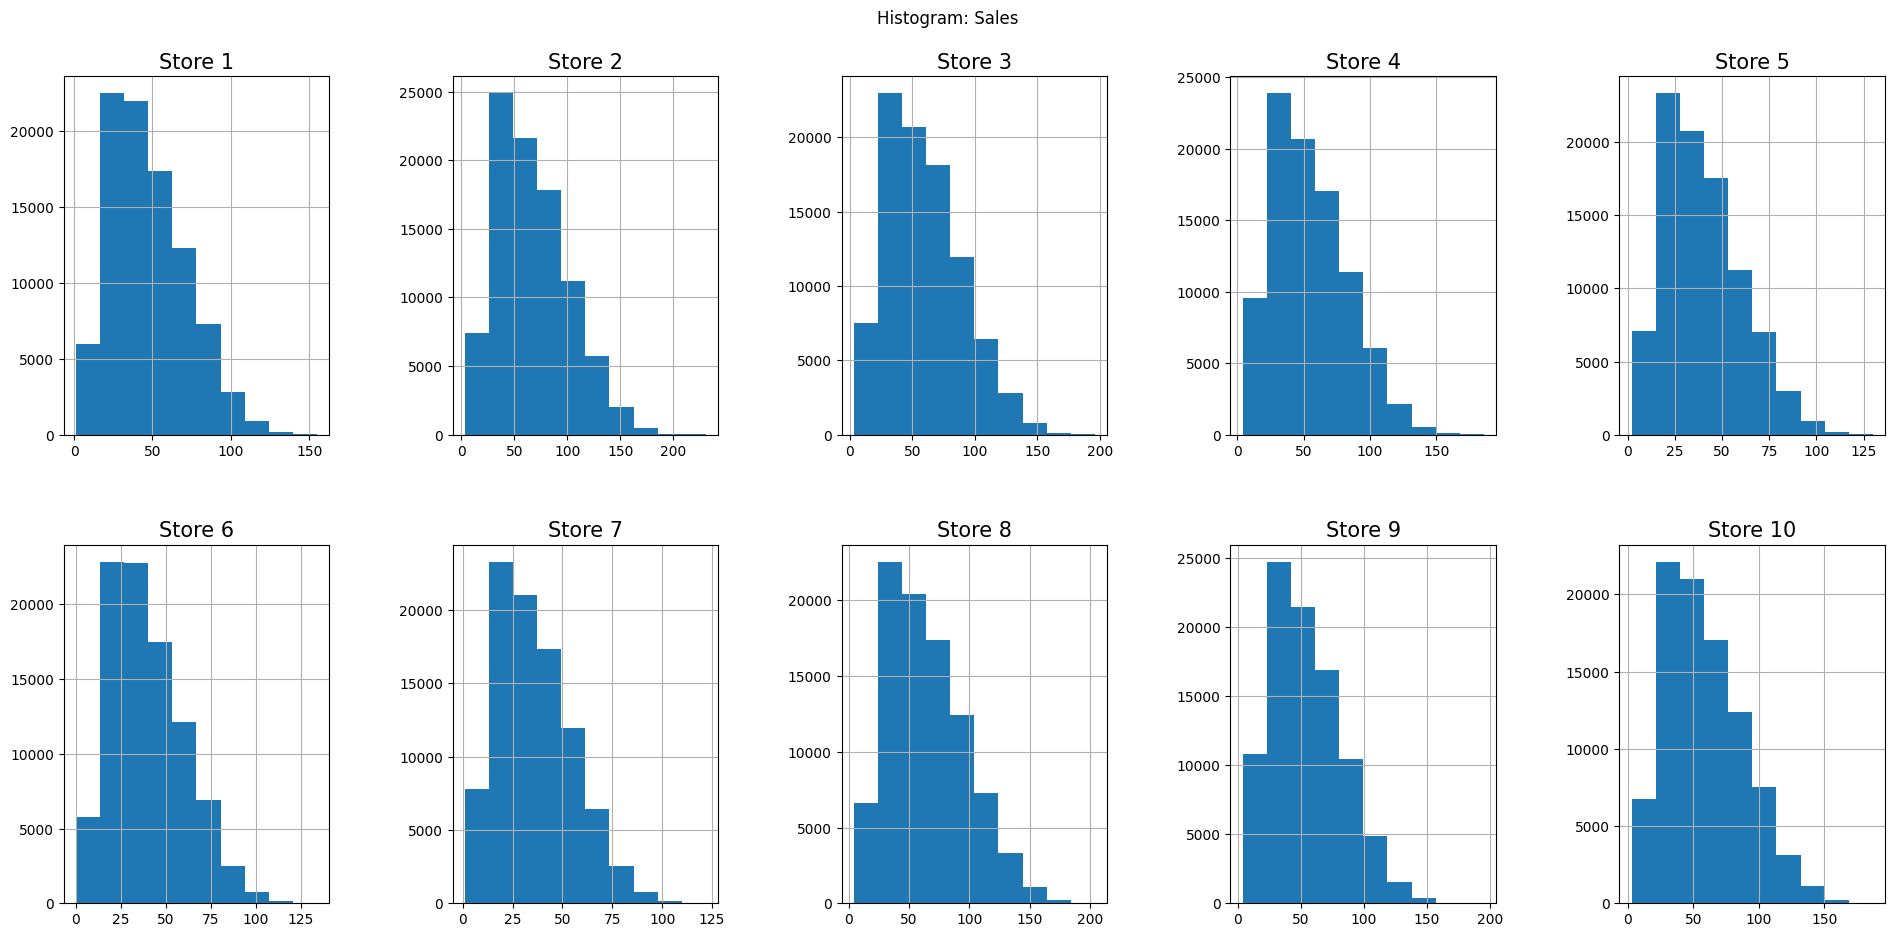

In [36]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1])
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15)
        
    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: Sales");

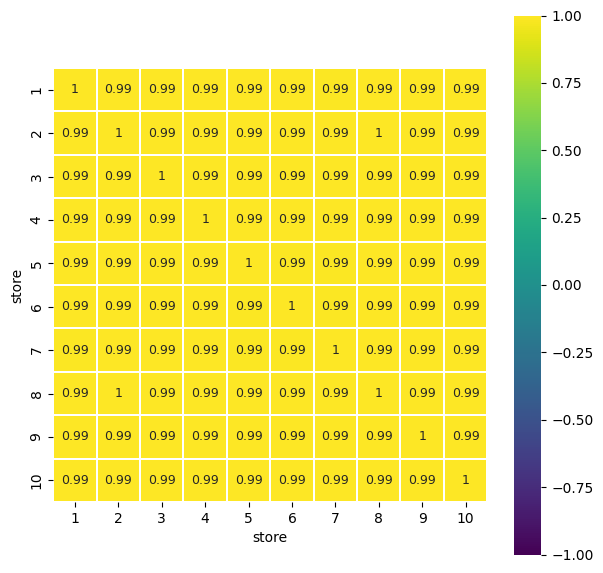

In [37]:
storesales = train.groupby(["date", "store"]).sales.sum().reset_index().set_index("date")
corr =  pd.pivot_table(storesales, values = "sales", columns="store", index="date").corr(method = "spearman")
plt.figure(figsize = (7,7))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

In [38]:
df.corr(method='pearson').style.background_gradient(cmap='rocket_r')

,store,item,sales,id
store,1.000000,0.000000,-0.008170,0.019900
item,0.000000,1.000000,-0.055998,0.999800
sales,-0.008170,-0.055998,1.000000,nan
id,0.019900,0.999800,nan,1.000000


#### Hypothesis Testing

##### Stores

In [39]:
# T Test
def CompareTwoGroups(dataframe, group, target):
    
    import itertools
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # 1. Normality Test: Shapiro Test
    # 2. Homogeneity Test: Levene Test
    # 3. Parametric or Non-Parametric T Test: T-Test, Welch Test, Mann Whitney U
    
    # Create Combinations
    item_comb = list(itertools.combinations(dataframe[group].unique(), 2))
    
    AB = pd.DataFrame()
    for i in range(0, len(item_comb)):
        # Define Groups
        groupA = dataframe[dataframe[group] == item_comb[i][0]][target]
        groupB = dataframe[dataframe[group] == item_comb[i][1]][target]
        
        # Assumption: Normality
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is Normal! - False
        # H1: Distribution is not Normal! - True
        
        if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
            # Parametric Test
            # Assumption: Homogeneity of variances
            leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True
            if leveneTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
            else:
                # Heterogeneous
                ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
        else:
            # Non-Parametric Test
            ttest = stats.mannwhitneyu(groupA, groupB)[1] 
            # H0: M1 = M2 - False
            # H1: M1 != M2 - True
            
        temp = pd.DataFrame({"Compare Two Groups":[ttest < 0.05], 
                             "p-value":[ttest],
                             "GroupA_Mean":[groupA.mean()], "GroupB_Mean":[groupB.mean()],
                             "GroupA_Median":[groupA.median()], "GroupB_Median":[groupB.median()],
                             "GroupA_Count":[groupA.count()], "GroupB_Count":[groupB.count()]
                            }, index = [item_comb[i]])
        temp["Compare Two Groups"] = np.where(temp["Compare Two Groups"] == True, "Different Groups", "Similar Groups")
        temp["TestType"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
        
        AB = pd.concat([AB, temp[["TestType", "Compare Two Groups", "p-value","GroupA_Median", "GroupB_Median","GroupA_Mean", "GroupB_Mean",
                                 "GroupA_Count", "GroupB_Count"]]])
        
    return AB
    
    
CompareTwoGroups(storesales, group = "store", target = "sales")

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(1, 2)",Non-Parametric,Different Groups,1.142171e-261,2339.5,3310.5,2363.418949,3351.658269,1826,1826
"(1, 3)",Non-Parametric,Different Groups,9.986606e-135,2339.5,2937.5,2363.418949,2976.530120,1826,1826
"(1, 4)",Non-Parametric,Different Groups,4.089808e-62,2339.5,2708.0,2363.418949,2745.147317,1826,1826
"(1, 5)",Non-Parametric,Different Groups,1.482497e-80,2339.5,1970.5,2363.418949,1988.508215,1826,1826
"(1, 6)",Non-Parametric,Different Groups,1.322467e-81,2339.5,1963.0,2363.418949,1986.675794,1826,1826
"(1, 7)",Non-Parametric,Different Groups,4.984442e-167,2339.5,1796.5,2363.418949,1818.186747,1826,1826
"(1, 8)",Non-Parametric,Different Groups,2.806842e-213,2339.5,3174.5,2363.418949,3207.102410,1826,1826
"(1, 9)",Non-Parametric,Different Groups,6.988553e-64,2339.5,2719.5,2363.418949,2752.451260,1826,1826
"(1, 10)",Non-Parametric,Different Groups,7.007060e-121,2339.5,2899.0,2363.418949,2935.464403,1826,1826
"(2, 3)",Non-Parametric,Different Groups,1.634782e-40,3310.5,2937.5,3351.658269,2976.530120,1826,1826


##### Items

In [40]:
itemsales = train.groupby(["date", "item"]).sales.sum().reset_index().set_index("date")
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")
ctg_is[ctg_is["Compare Two Groups"] == "Similar Groups"]

,TestType,Compare Two Groups,p-value,GroupA_Median,GroupB_Median,GroupA_Mean,GroupB_Mean,GroupA_Count,GroupB_Count
"(1, 4)",Non-Parametric,Similar Groups,0.842383,218.0,218.0,219.815991,220.102410,1826,1826
"(1, 27)",Non-Parametric,Similar Groups,0.746252,218.0,218.0,219.815991,220.497262,1826,1826
"(1, 41)",Non-Parametric,Similar Groups,0.961622,218.0,218.0,219.815991,220.021358,1826,1826
"(1, 47)",Non-Parametric,Similar Groups,0.946145,218.0,217.0,219.815991,220.033406,1826,1826
"(2, 6)",Non-Parametric,Similar Groups,0.899452,578.0,578.5,585.741512,585.038883,1826,1826
...,...,...,...,...,...,...,...,...,...
"(40, 44)",Non-Parametric,Similar Groups,0.489586,289.0,291.0,292.493976,293.981928,1826,1826
"(40, 49)",Non-Parametric,Similar Groups,0.769478,289.0,289.0,292.493976,293.353231,1826,1826
"(41, 47)",Non-Parametric,Similar Groups,0.993689,218.0,217.0,220.021358,220.033406,1826,1826
"(43, 48)",Non-Parametric,Similar Groups,0.902335,508.5,506.0,512.943593,513.528478,1826,1826


# Feature Engineering

- Time Related Features
- Lagged Features
- Moving Average Features
- Hypothesis Testing: Similarity Features
- Exponentially Weighted Mean Features

In [41]:
# 1. Time Related Features
#####################################################
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["quarter"] = df.date.dt.quarter
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    return df
df = create_date_features(df)


# Rolling Summary Stats Features
#####################################################
for i in [91, 98, 105, 112, 119, 126, 186, 200, 210, 250, 300, 365, 546, 700]:
    df["sales_roll_mean_"+str(i)]=df.groupby(["store", "item"]).sales.rolling(i).mean().shift(1).values

# 2. Hypothesis Testing: Similarity
#####################################################

# Store Based
storesales = train.groupby(["date", "store"]).sales.sum().reset_index()
ctg_ss = CompareTwoGroups(storesales, group="store", target="sales")
del storesales

df["StoreSalesSimilarity"] = np.where(df.store.isin([3,10]), 1, 0)
df["StoreSalesSimilarity"] = np.where(df.store.isin([4,9]), 2, df["StoreSalesSimilarity"])
df["StoreSalesSimilarity"] = np.where(df.store.isin([5,6]), 3, df["StoreSalesSimilarity"])

# Item Based

itemsales = train.groupby(["date", "item"]).sales.sum().reset_index()
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")
del itemsales

df["ItemSalesSimilarity"] = np.where(df.item.isin([1,4,27,41,47]), 1, 0)
df["ItemSalesSimilarity"] = np.where(df.item.isin([2,6,7,14,31,46]), 2, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([3,42]), 3, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([8,36]), 4, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([9,43,48]), 5, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([11,12,29,33]), 6, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([13,18]), 7, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([15,28]), 8, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([16,34]), 9, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([19,21,30]), 10, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([20,26]), 11, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([22,25,38,45]), 12, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([23,37,40,44,49]), 13, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([24,35,50]), 14, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([32,39]), 15, df["ItemSalesSimilarity"])

# 3. Lag/Shifted Features
#####################################################

# test.groupby(["store", "item"]).date.count()
# Test verisinde +90 gün tahmin edilmesi isteniyor bu yüzden
# Lag featureları en az 91 olmalı!

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

def lag_features(dataframe, lags, groups = ["store", "item"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe

df = lag_features(df, lags = [91, 92,93,94,95,96, 97, 98, 100, 105, 112, 119, 126, 150,
                              182,200,220, 250, 300, 350, 355, 360,361,362,363, 364,
                              365, 370, 375,380, 546, 600, 650, 680, 690, 700, 710, 728,
                              730, 800, 900, 950, 990, 1000, 1050, 1090, 1095],
                  groups = ["store", "item"], target = 'sales', prefix = 'sales_lag_')

def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+["sales"]].corr().sales.sort_values(ascending = False).index[1:index]
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(df, "sales_lag", 16)

# pd.cut
clus = df.groupby(["store"]).sales.mean().reset_index()
clus["store_cluster"] =  pd.cut(clus.sales, bins = 4, labels = range(1,5))
clus.drop("sales", axis = 1, inplace = True)
df = pd.merge(df, clus, how = "left")
clus = df.groupby(["item"]).sales.mean().reset_index()
clus["item_cluster"] =  pd.cut(clus.sales, bins = 5, labels = range(1,6))
clus.drop("sales", axis = 1, inplace = True)
df = pd.merge(df, clus, how = "left")
del clus

df.shape

(958000, 53)

# Train-Validation Split

In [42]:
# Dataframe must be sorted by date because of Time Series Split 
df = df.sort_values("date").reset_index(drop = True)

# Train Validation Split
# Validation set includes 3 months (Oct. Nov. Dec. 2017)
train = df.loc[(df["date"] < "2017-10-01"), :]
val = df.loc[(df["date"] >= "2017-10-01") & (df["date"] < "2018-01-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((867000,), (867000, 49), (46000,), (46000, 49))

# Custom Cost Function

If you want to see the SMAPE formula, click [here](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error).

In [43]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False


# First Model

### Default Parameters

In [44]:
len(df.columns)

53

In [45]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 13.11611206137427
VALID SMAPE: 12.982708194666117


# Feature Importance

In [46]:

def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    # LGBM API
    # gain = model.feature_importance('gain')
    # feat_imp = pd.DataFrame({'feature': model.feature_name(),
    #                         'split': model.feature_importance('split'),
    #                         'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                            'split': model.booster_.feature_importance(importance_type='split'),
                            'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

                 feature  split       gain
38         sales_lag_364    445  52.036520
32         sales_lag_350    155  19.280839
48          item_cluster    237  14.060356
47         store_cluster    161   2.454997
15                season    123   1.995987
6            day_of_week    225   1.707761
40         sales_lag_370     45   1.393768
43         sales_lag_728    109   1.271584
37         sales_lag_363     56   1.223714
39         sales_lag_365     86   1.133085
41         sales_lag_380     74   0.740630
36         sales_lag_362     45   0.529764
31   ItemSalesSimilarity    233   0.366851
2                  month    210   0.351813
5           week_of_year     40   0.346516
42         sales_lag_700     82   0.190772
4            day_of_year    106   0.181213
44         sales_lag_730     72   0.164313
34         sales_lag_360     81   0.129774
35         sales_lag_361     74   0.109474
33         sales_lag_355     61   0.091408
30  StoreSalesSimilarity     37   0.077347
0          

# Shap

In [47]:
explainer = shap.Explainer(first_model)
shap_values_train = explainer(X_train)

len(shap_values_train)

867000

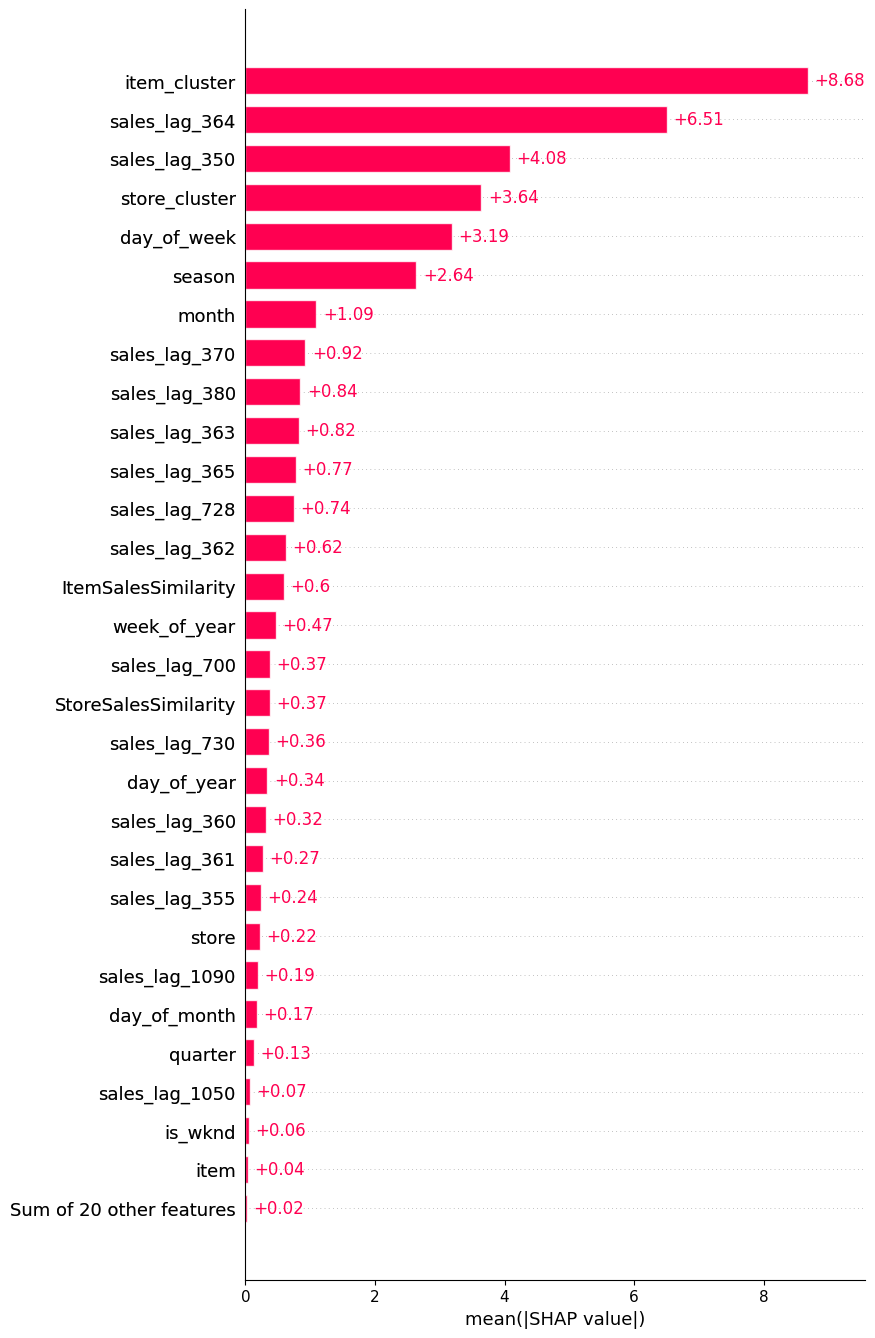

In [48]:
shap.plots.bar(shap_values_train, max_display=30)

# Next Model

### Default Parameters & Feature Selection with LGBM Feature Importance

In [49]:
# First model feature importance
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

second_model = lgb.LGBMRegressor(random_state=384).fit(
    X_train[cols], Y_train, 
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val[cols])))

Independent Variables: 25
TRAIN SMAPE: 13.113315588281512
VALID SMAPE: 12.997677559642673


**First Model Scores**

- TRAIN SMAPE: 13.1161
- VALID SMAPE: 12.9827
- 53 Features

**Second Model Scores**
- TRAIN SMAPE: 13.1133
- VALID SMAPE: 12.9976
- 25 Features

# Hyperparameter Tuning

There are two steps to tune LGBM models!

- **1st Optimization:** Finding other parameters when the number of iterations is constant (GridSearchedCV, RandomSearchedCV etc.)
- **2nd Optimization:** Finding best iteration number by using early stopping round

**Hyperparameter tuning takes too long because of high iteration number and data dimension, that's why I add the Random Search CV algorithm below as text.**

In [50]:
# Best Params: {'num_leaves': 31, 'n_estimators': 15000, 'max_depth': 20}
# model_tuned2 = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384, metric = "custom")

model_tuned2 = lgb.LGBMRegressor(num_leaves=31, n_estimators=15000, max_depth=20, random_state=384, metric = "custom")
              
model_tuned2.fit(
    X_train[cols], Y_train,
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)],
    eval_set = [(X_train[cols], Y_train), (X_val[cols], Y_val)],
    eval_names = ["Train", "Valid"],
    early_stopping_rounds= 1000, verbose = 500
)
print("Best Iteration:", model_tuned2.booster_.best_iteration)

[500]	Train's SMAPE: 12.6975	Valid's SMAPE: 12.5744
[1000]	Train's SMAPE: 12.5462	Valid's SMAPE: 12.4795
[1500]	Train's SMAPE: 12.4197	Valid's SMAPE: 12.4405
[2000]	Train's SMAPE: 12.3076	Valid's SMAPE: 12.4374
[2500]	Train's SMAPE: 12.2022	Valid's SMAPE: 12.4387
Best Iteration: 1751


**First Model Scores**

- TRAIN SMAPE: 13.1559
- VALID SMAPE: 12.7387
- 53 Features
- Default hyperparameters

**Second Model Scores**

- TRAIN SMAPE: 13.1598
- VALID SMAPE: 12.7291
- 25 Features
- Default hyperparameters


**Third Model Scores**

- TRAIN SMAPE: 12.5183
- VALID SMAPE: 12.4974
- 25 Features
- Hyperparameter Tuning: Random Searched CV 
- Best iteration number: 983



#### Second Optimization: Find best iteration number

In [51]:
# Best Params: {'num_leaves': 31, 'n_estimators': 15000, 'max_depth': 20}
# model_tuned2 = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384, metric = "custom")

model_tuned2 = lgb.LGBMRegressor(num_leaves=31, n_estimators=15000, max_depth=20, random_state=384, metric = "custom")
              
model_tuned2.fit(
    X_train[cols], Y_train,
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)],
    eval_set = [(X_train[cols], Y_train), (X_val[cols], Y_val)],
    eval_names = ["Train", "Valid"],
    early_stopping_rounds= 1000, verbose = 500
)
print("Best Iteration:", model_tuned2.booster_.best_iteration)

[500]	Train's SMAPE: 12.6975	Valid's SMAPE: 12.5744
[1000]	Train's SMAPE: 12.5462	Valid's SMAPE: 12.4795
[1500]	Train's SMAPE: 12.4197	Valid's SMAPE: 12.4405
[2000]	Train's SMAPE: 12.3076	Valid's SMAPE: 12.4374
[2500]	Train's SMAPE: 12.2022	Valid's SMAPE: 12.4387
Best Iteration: 1751


# Final Model

In [52]:
df.sort_values(["store", "item", "date"], inplace = True)

train_final = df.loc[(df["date"] < "2018-01-01"), :]
test_final = df.loc[(df["date"] >= "2018-01-01"), :]

X_train_final = train_final[cols]
Y_train_final = train_final.sales
X_test_final = test_final[cols]


#final_model = lgb.LGBMRegressor(**rsearch.best_params_, random_state=384, metric = "custom") # Tuned parameters
# Best Params: {'num_leaves': 31, 'n_estimators': 15000, 'max_depth': 20}
final_model = lgb.LGBMRegressor(num_leaves=31, n_estimators=15000, max_depth=20, random_state=384, metric = "custom")
final_model.set_params(n_estimators=model_tuned2.booster_.best_iteration) # Best Iteration: 1751
final_model.fit(X_train_final[cols], Y_train_final,
                eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])
                
print("TRAIN SMAPE:", smape(Y_train, final_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, final_model.predict(X_val[cols])))                

TRAIN SMAPE: 12.387596775171248
VALID SMAPE: 11.867574961871657


In [53]:
test_final.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,sales_roll_mean_91,sales_roll_mean_98,sales_roll_mean_105,sales_roll_mean_112,sales_roll_mean_119,sales_roll_mean_126,sales_roll_mean_186,sales_roll_mean_200,sales_roll_mean_210,sales_roll_mean_250,sales_roll_mean_300,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_700,StoreSalesSimilarity,ItemSalesSimilarity,sales_lag_350,sales_lag_355,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_370,sales_lag_380,sales_lag_700,sales_lag_728,sales_lag_730,sales_lag_1050,sales_lag_1090,store_cluster,item_cluster
913414,2018-01-01,1,1,NaN,0.0,1,1,1,1,1,2018,0,1,1,0,1,0,1,0,0,29.131868,29.193878,29.085714,29.303571,29.462185,29.373016,27.688172,27.185,26.761905,25.220,24.323333,24.378082,25.260073,23.610000,0,1,15.0,14.0,24.0,14.0,16.0,10.0,15.0,19.0,10.0,19.0,16.0,12.0,13.0,14.0,13.0,2,1
913586,2018-01-02,1,1,NaN,1.0,1,2,2,1,2,2018,0,1,0,0,0,0,0,0,0,29.087912,29.163265,29.066667,29.258929,29.445378,29.246032,27.736559,27.220,26.828571,25.272,24.300000,24.378082,25.280220,23.612857,0,1,14.0,17.0,14.0,24.0,14.0,16.0,10.0,15.0,16.0,22.0,16.0,12.0,12.0,16.0,18.0,2,1
914471,2018-01-03,1,1,NaN,2.0,1,3,3,1,3,2018,0,1,0,0,0,0,0,0,0,29.076923,29.142857,29.085714,29.330357,29.369748,29.261905,27.768817,27.310,26.861905,25.332,24.336667,24.372603,25.298535,23.620000,0,1,10.0,7.0,20.0,14.0,24.0,14.0,16.0,10.0,21.0,17.0,19.0,16.0,12.0,16.0,18.0,2,1
914800,2018-01-04,1,1,NaN,3.0,1,4,4,1,4,2018,0,1,0,0,0,0,0,0,0,29.043956,29.142857,29.000000,29.294643,29.268908,29.301587,27.758065,27.320,26.871429,25.348,24.313333,24.367123,25.313187,23.625714,0,1,16.0,16.0,18.0,20.0,14.0,24.0,14.0,16.0,24.0,18.0,9.0,12.0,12.0,11.0,17.0,2,1
915370,2018-01-05,1,1,NaN,4.0,1,5,5,1,5,2018,1,1,0,0,0,0,0,0,0,28.945055,29.030612,28.942857,29.187500,29.159664,29.293651,27.731183,27.360,26.861905,25.376,24.310000,24.394521,25.320513,23.634286,0,1,22.0,29.0,11.0,18.0,20.0,14.0,24.0,14.0,14.0,12.0,14.0,12.0,16.0,10.0,19.0,2,1


In [54]:
test_final[cols].tail()

,sales_lag_364,sales_lag_350,item_cluster,store_cluster,season,day_of_week,sales_lag_370,sales_lag_728,sales_lag_363,sales_lag_365,sales_lag_380,sales_lag_362,ItemSalesSimilarity,month,week_of_year,sales_lag_700,day_of_year,sales_lag_730,sales_lag_360,sales_lag_361,sales_lag_355,StoreSalesSimilarity,store,day_of_month,sales_lag_1090
955853,60.0,72.0,4,3,1,2,57.0,73.0,73.0,66.0,80.0,68.0,14,3,13,77.0,86,83.0,101.0,69.0,78.0,1,10,27,77.0
956111,73.0,79.0,4,3,1,3,67.0,68.0,68.0,60.0,63.0,69.0,14,3,13,85.0,87,51.0,110.0,101.0,90.0,1,10,28,79.0
956611,68.0,79.0,4,3,1,4,73.0,75.0,69.0,73.0,62.0,101.0,14,3,13,89.0,88,73.0,64.0,110.0,90.0,1,10,29,81.0
957418,69.0,103.0,4,3,1,5,79.0,83.0,101.0,68.0,51.0,110.0,14,3,13,83.0,89,68.0,106.0,64.0,114.0,1,10,30,77.0
957999,101.0,97.0,4,3,1,6,81.0,82.0,110.0,69.0,83.0,64.0,14,3,13,99.0,90,75.0,69.0,106.0,54.0,1,10,31,52.0


In [55]:
X_test_final.tail()


,sales_lag_364,sales_lag_350,item_cluster,store_cluster,season,day_of_week,sales_lag_370,sales_lag_728,sales_lag_363,sales_lag_365,sales_lag_380,sales_lag_362,ItemSalesSimilarity,month,week_of_year,sales_lag_700,day_of_year,sales_lag_730,sales_lag_360,sales_lag_361,sales_lag_355,StoreSalesSimilarity,store,day_of_month,sales_lag_1090
955853,60.0,72.0,4,3,1,2,57.0,73.0,73.0,66.0,80.0,68.0,14,3,13,77.0,86,83.0,101.0,69.0,78.0,1,10,27,77.0
956111,73.0,79.0,4,3,1,3,67.0,68.0,68.0,60.0,63.0,69.0,14,3,13,85.0,87,51.0,110.0,101.0,90.0,1,10,28,79.0
956611,68.0,79.0,4,3,1,4,73.0,75.0,69.0,73.0,62.0,101.0,14,3,13,89.0,88,73.0,64.0,110.0,90.0,1,10,29,81.0
957418,69.0,103.0,4,3,1,5,79.0,83.0,101.0,68.0,51.0,110.0,14,3,13,83.0,89,68.0,106.0,64.0,114.0,1,10,30,77.0
957999,101.0,97.0,4,3,1,6,81.0,82.0,110.0,69.0,83.0,64.0,14,3,13,99.0,90,75.0,69.0,106.0,54.0,1,10,31,52.0


# Submission

In [56]:
import pickle
pickle.dump(final_model, open("final_model.pkl", "wb"))

In [57]:
submission = pd.DataFrame({
    "id":test_final.id.astype(int),
    "sales":final_model.predict(X_test_final)
})
submission.to_csv("submission.csv", index = None)

In [58]:
submission[["sales"]].describe([0.1, 0.75, 0.8, 0.9, 0.95, 0.99]).T

,count,mean,std,min,10%,50%,75%,80%,90%,95%,99%,max
sales,45000.0,46.755717,23.452928,7.336305,19.117423,43.325567,61.852877,66.720248,79.759493,90.339055,110.108906,145.486607


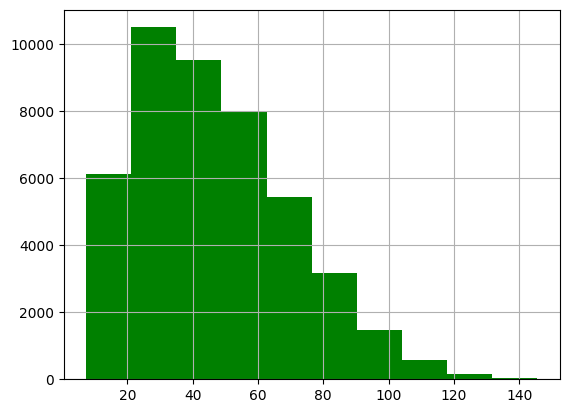

In [59]:
submission.sales.hist(color = "g");

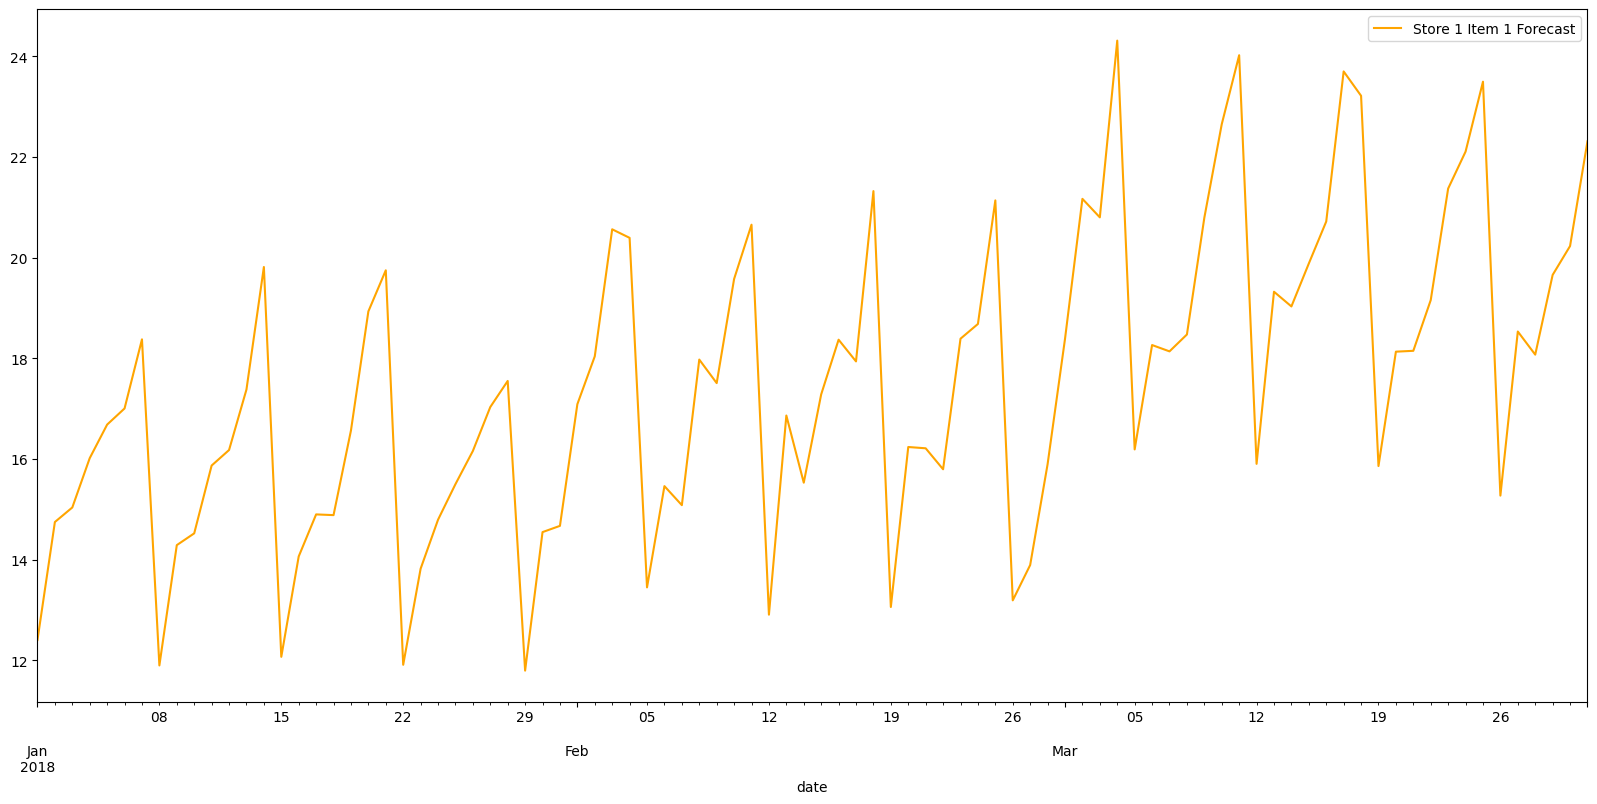

In [60]:
forecast = pd.DataFrame({
    "date":test_final.date,
    "store":test_final.store,
    "item":test_final.item,
    "sales":final_model.predict(X_test_final)
})

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

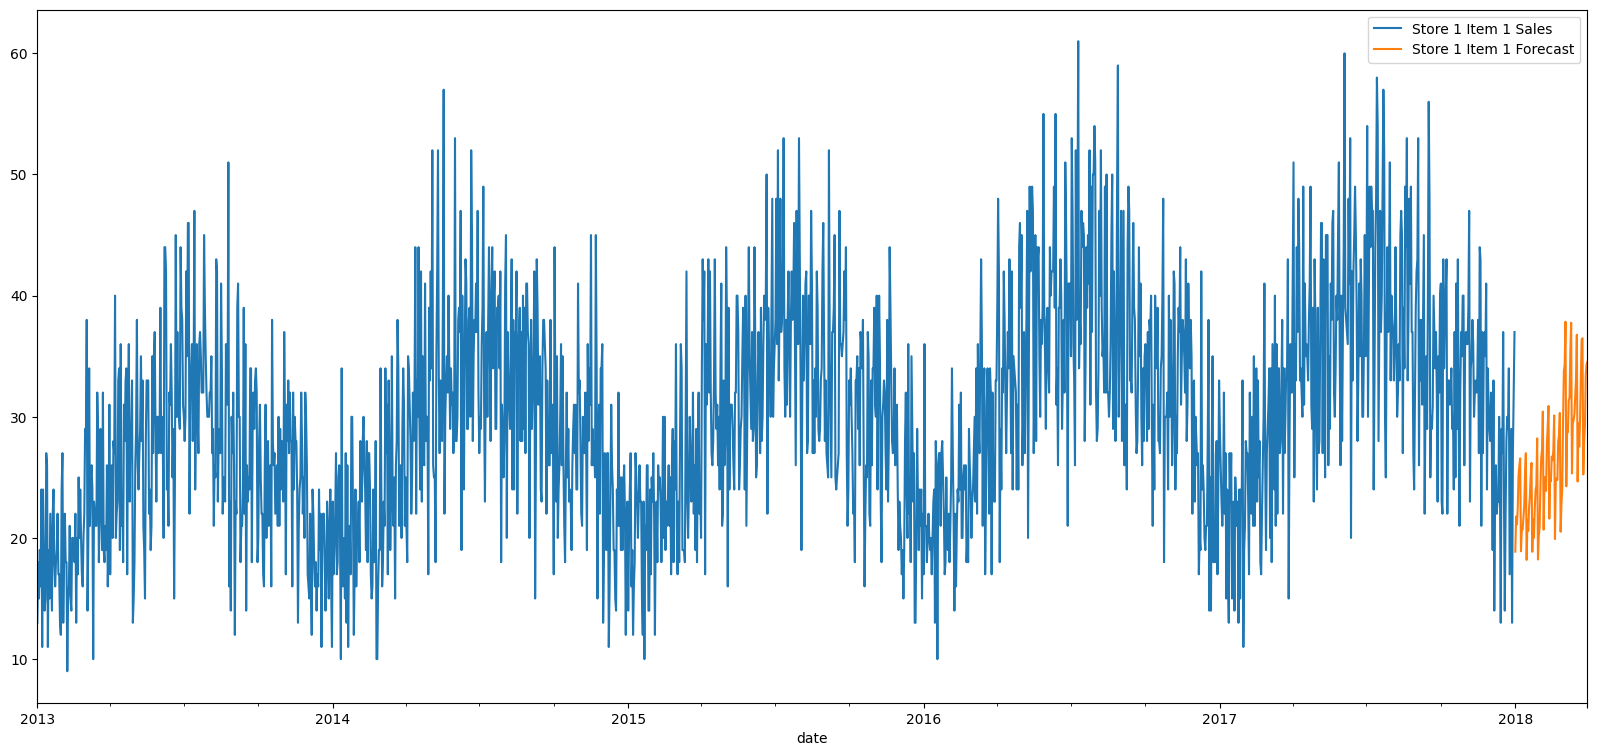

In [61]:
train_final[(train_final.store == 1) & (train_final.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 1 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 1 Forecast");

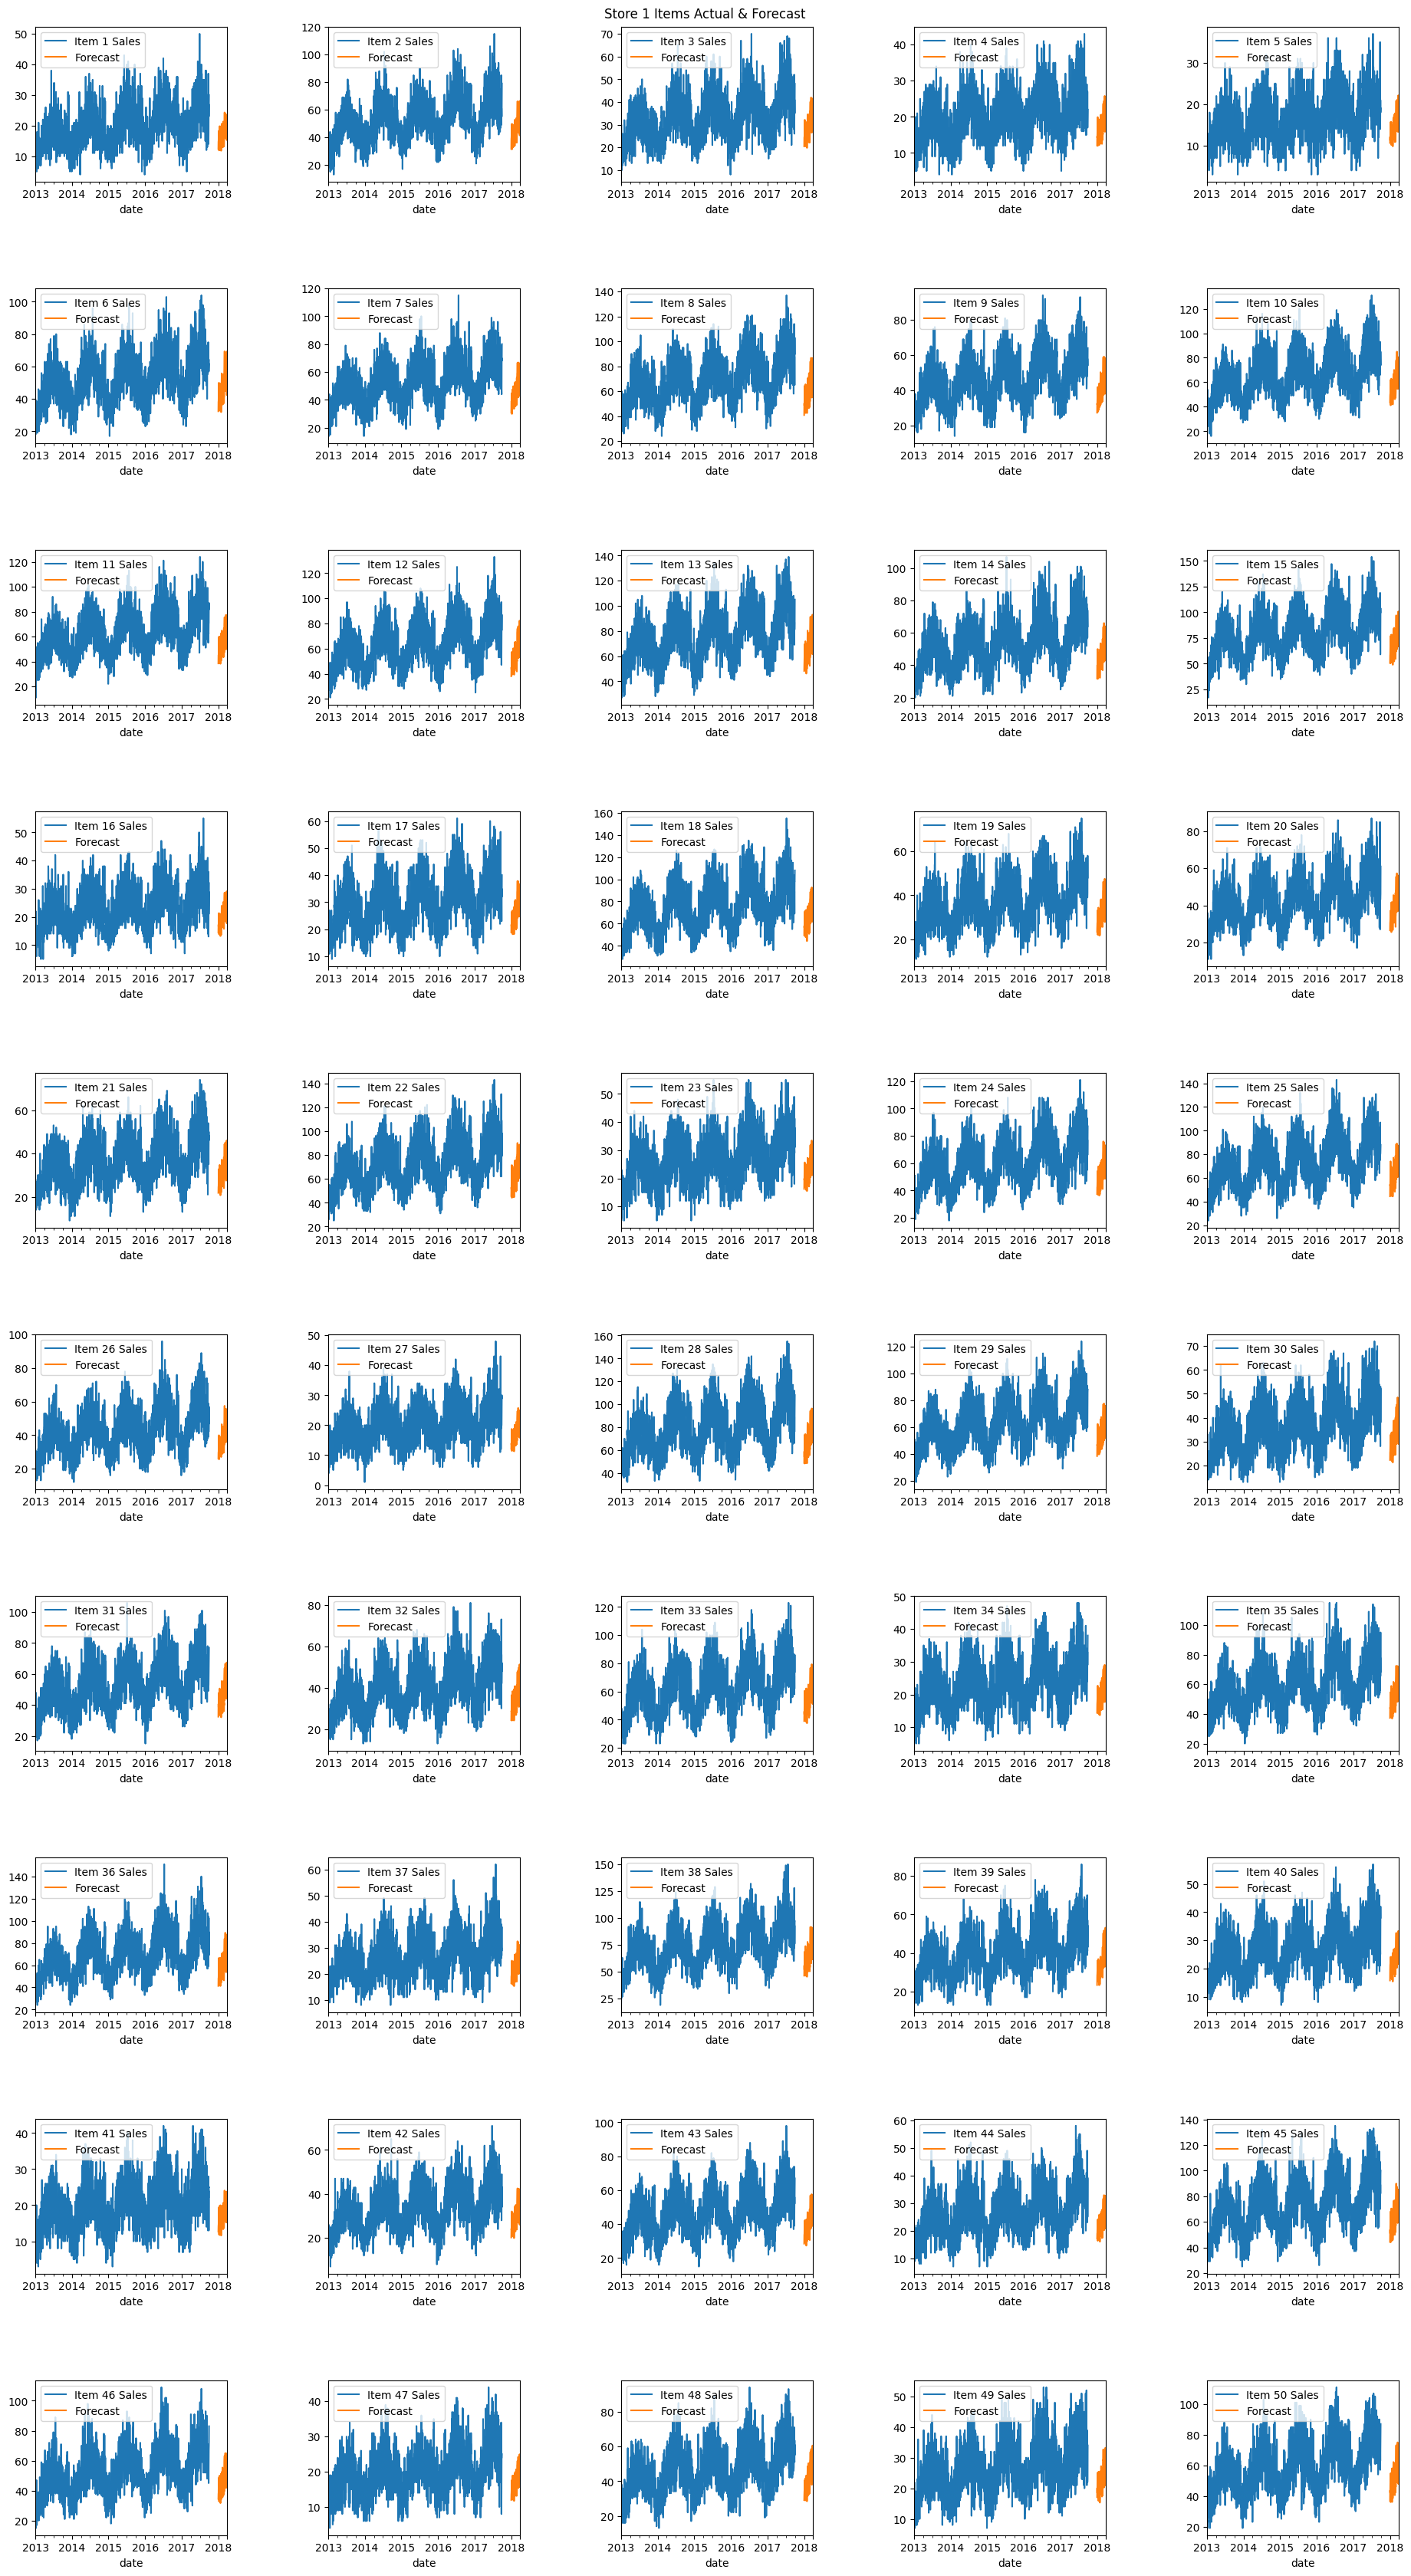

In [62]:
store = 1
sub = train[train.store == store].set_index("date")
forc = forecast[forecast.store == store].set_index("date")


fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Forecast")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[1, i-6], legend=True, label = "Forecast")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[2, i-11], legend=True, label = "Forecast")
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
        forc[forc.item == i].sales.plot(ax=axes[3, i-16], legend=True, label = "Forecast")
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[4, i-21], legend=True, label = "Forecast")
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[5, i-26], legend=True, label = "Forecast")
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")  
        forc[forc.item == i].sales.plot(ax=axes[6, i-31], legend=True, label = "Forecast")
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[7, i-36], legend=True, label = "Forecast")
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[8, i-41], legend=True, label = "Forecast")
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[9, i-46], legend=True, label = "Forecast")
plt.tight_layout(pad=6.5)
plt.suptitle("Store 1 Items Actual & Forecast");